In [59]:
import time
import random
import warnings
import opensimplex

import scipy.interpolate

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import metrics
from tqdm.auto import tqdm

In [60]:
class Data(dict):
    x=None
    y=None
    x_sample=None
    y_sample=None
    interpolation={}

    def __init__(self, x: np.ndarray=np.linspace(0, 1, 100, endpoint=False)):
        self.x = x

    def generate_data(self, noise_x_offset:float=3.14, noise_octave: int=4):
        self.y = np.array([opensimplex.noise2(noise_x_offset, e*noise_octave) for e in self.x])

    def sample(self, ratio:float=0.5):
        n = len(self.x)
        ind = np.array(range(n))
        random.shuffle(ind)
        ind = sorted(ind[:int(n * ratio)])
        self.x_sample = self.x[ind]
        self.y_sample = self.y[ind]

    def interpolate(self, guesser_class=scipy.interpolate.CubicSpline, key:str=None):
        guesser = guesser_class(self.x_sample, self.y_sample)
        y_pred = guesser(self.x)
        key = type(guesser) if key is None else key
        self.interpolation[key] = dict(
            guesser=guesser,
            guesser_name=key,
            y=y_pred
        )
        return self.interpolation[key]

    def plot(self):
        fig, ax = plt.subplots(1, 1, figsize=(10, 4))
        ax.plot(self.x, self.y, label='Raw curve', c='black')
        ax.scatter(self.x_sample, self.y_sample, label='Sample', c='black')

        for key, value in self.interpolation.items():
            y = value['y']
            ax.plot(self.x, y, label=f'Prediction: {key}', alpha=0.5)

        ax.legend(
            loc='upper left',
            bbox_to_anchor=(1, 1), #(0.5, 1.05),
            ncol=1,
            fancybox=True,
            shadow=True
            )
        ax.set_ylim([-1.1, 1.1])
        ax.grid()
        return fig, ax


def seed(n:int=time.time_ns()):
    opensimplex.seed(time.time_ns())


Try interpolate methods:   0%|          | 0/87 [00:00<?, ?it/s]

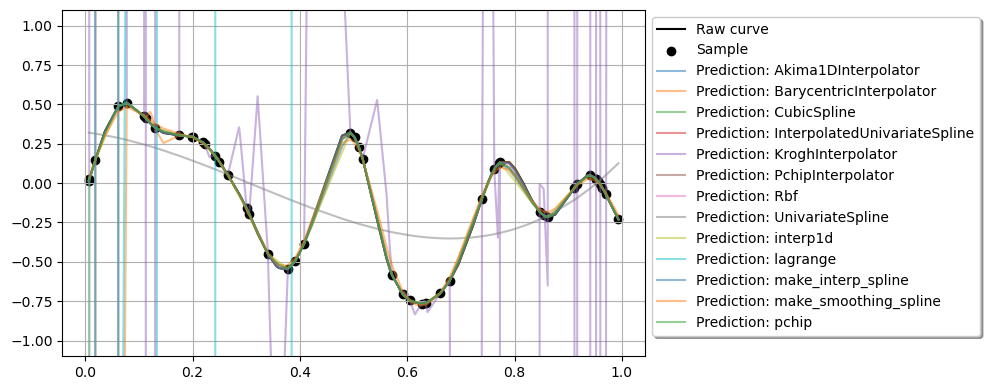

In [61]:
seed()
x = np.array(list(sorted(set(np.random.random((100, ))))))
data = Data(x)
data.generate_data(noise_octave=8)
data.sample()

for key in tqdm(dir(scipy.interpolate), 'Try interpolate methods'):
    c = scipy.interpolate.__getattribute__(key)
    try:
        with warnings.catch_warnings(action='ignore'):
            data.interpolate(c, key=key)
    except:
        pass

data.plot()
plt.tight_layout()
plt.show()

In [62]:
array = []

y_true = data.y
for metrics_name in tqdm(metrics._regression.__ALL__, 'Metrics'):
    ruler = eval(f'metrics.{metrics_name}')
    for key in data.interpolation:
        y_pred = data.interpolation[key]['y']
        # y_pred = np.nan_to_num(y_pred, 0)
        try:
            ax = ruler(y_true=y_true, y_pred=y_pred)
            array.append(dict(
                metrics=metrics_name,
                category=metrics_name.split('_')[-1],
                interpolate=key,
                value=ax,
                abs_value=np.abs(ax)
            ))
        except:
            pass

df = pd.DataFrame(array)
df

Metrics:   0%|          | 0/17 [00:00<?, ?it/s]

,metrics,category,interpolate,value,abs_value
0,max_error,error,Akima1DInterpolator,6.929723e-02,6.929723e-02
1,max_error,error,BarycentricInterpolator,1.011326e+04,1.011326e+04
2,max_error,error,CubicSpline,1.015766e-02,1.015766e-02
3,max_error,error,InterpolatedUnivariateSpline,1.015766e-02,1.015766e-02
4,max_error,error,KroghInterpolator,1.295728e+08,1.295728e+08
...,...,...,...,...,...
164,d2_absolute_error_score,score,interp1d,9.686538e-01,9.686538e-01
165,d2_absolute_error_score,score,lagrange,-7.747314e+22,7.747314e+22
166,d2_absolute_error_score,score,make_interp_spline,9.965430e-01,9.965430e-01
167,d2_absolute_error_score,score,make_smoothing_spline,9.340096e-01,9.340096e-01


error Axes(0.122076,0.116837;0.200186x0.814497)
loss Axes(0.331722,0.116837;0.200186x0.814497)
score Axes(0.541367,0.116837;0.200186x0.814497)
deviance Axes(0.751012,0.116837;0.200186x0.814497)


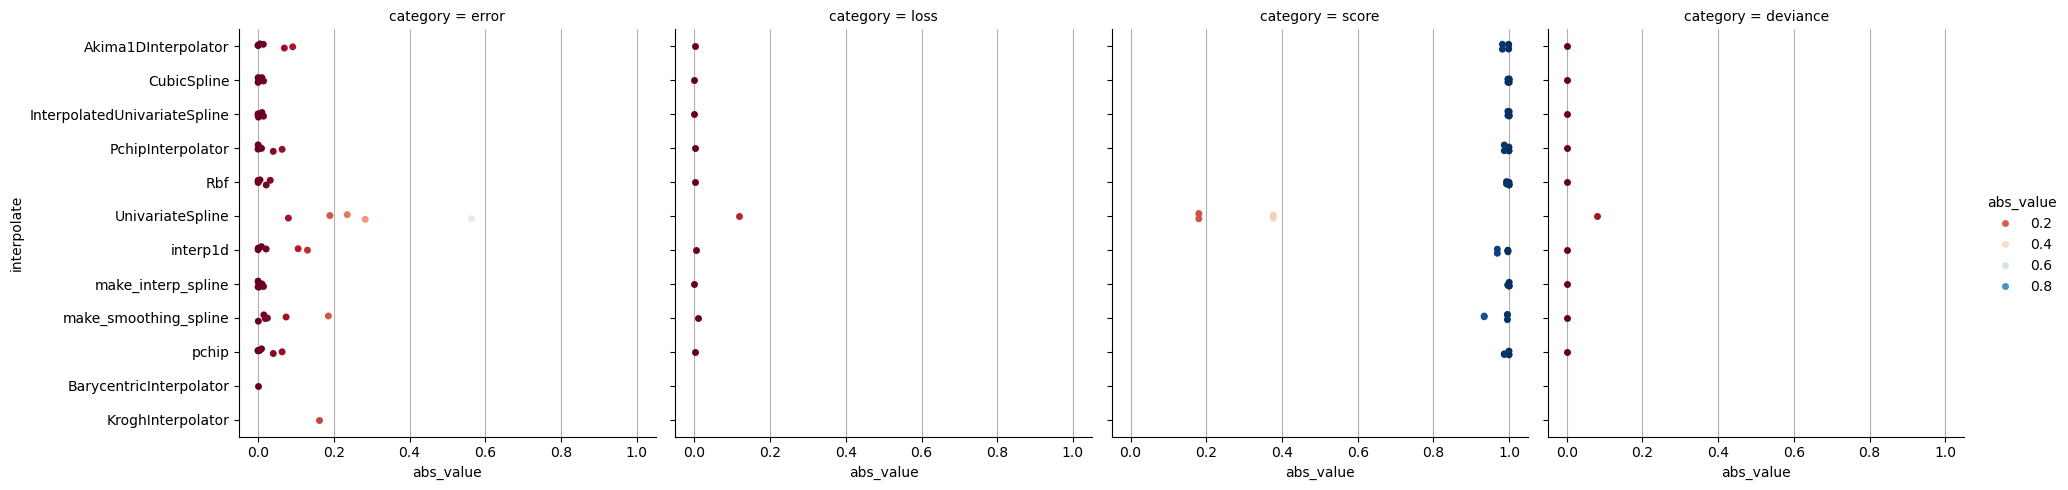

In [63]:
g = sns.catplot(df[df['abs_value'] < 1], y='interpolate', x='abs_value', col='category', hue='abs_value', palette='RdBu')
for key, ax in g.axes_dict.items():
    print(key, ax)
    ax.grid(axis='x', which='both')
plt.show()

max_error Axes(0.244153,0.116556;0.355174x0.814778)
mean_squared_error Axes(0.629826,0.116556;0.355174x0.814778)


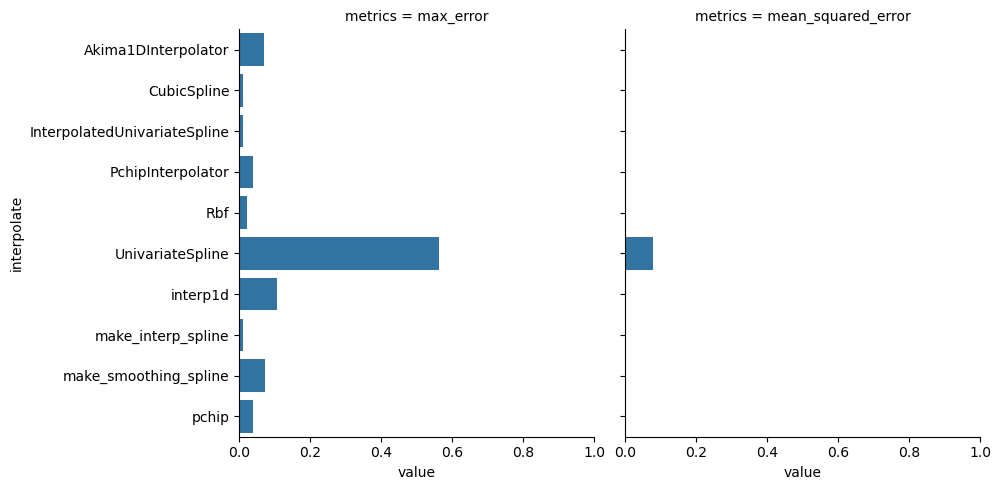

In [64]:
_df = df[df['metrics'].map(lambda e: e in ['max_error', 'mean_squared_error'])]
_df = _df.query('value < 1')
g = sns.catplot(_df, kind='bar', y='interpolate', x='value', col='metrics', sharex=False)

for key, ax in g.axes_dict.items():
    print(key, ax)
    ax.set_xlim(0, 1)

plt.show()

In [65]:
cross_df = pd.crosstab(df['interpolate'], df['metrics'], df['value'], aggfunc=lambda d: d)
cross_df

metrics,d2_absolute_error_score,d2_pinball_score,d2_tweedie_score,explained_variance_score,max_error,mean_absolute_error,mean_absolute_percentage_error,mean_pinball_loss,mean_squared_error,mean_tweedie_deviance,median_absolute_error,r2_score,root_mean_squared_error
interpolate,,,,,,,,,,,,,
Akima1DInterpolator,9.820821e-01,9.820821e-01,9.985249e-01,9.985783e-01,6.929723e-02,5.147461e-03,9.140380e-02,2.573731e-03,1.894860e-04,1.894860e-04,2.987959e-06,9.985249e-01,1.376539e-02
BarycentricInterpolator,-6.700523e+02,-6.700523e+02,-1.449008e+07,-1.448938e+07,1.011326e+04,1.927797e+02,1.290067e+03,9.638984e+01,1.861355e+06,1.861355e+06,8.201370e-07,-1.449008e+07,1.364315e+03
CubicSpline,9.965430e-01,9.965430e-01,9.999512e-01,9.999513e-01,1.015766e-02,9.931286e-04,1.431573e-02,4.965643e-04,6.268322e-06,6.268322e-06,1.843672e-07,9.999512e-01,2.503662e-03
InterpolatedUnivariateSpline,9.965430e-01,9.965430e-01,9.999512e-01,9.999513e-01,1.015766e-02,9.931286e-04,1.431573e-02,4.965643e-04,6.268322e-06,6.268322e-06,1.843672e-07,9.999512e-01,2.503662e-03
KroghInterpolator,-8.476633e+06,-8.476633e+06,-2.315805e+15,-2.315615e+15,1.295728e+08,2.435165e+06,1.615575e+07,1.217582e+06,2.974817e+14,2.974817e+14,1.617016e-01,-2.315805e+15,1.724766e+07
PchipInterpolator,9.870455e-01,9.870455e-01,9.993560e-01,9.993748e-01,4.005313e-02,3.721562e-03,6.337732e-02,1.860781e-03,8.272177e-05,8.272177e-05,7.516012e-07,9.993560e-01,9.095151e-03
Rbf,9.929064e-01,9.929064e-01,9.998020e-01,9.998043e-01,2.143662e-02,2.037836e-03,3.212585e-02,1.018918e-03,2.542826e-05,2.542826e-05,6.441882e-08,9.998020e-01,5.042644e-03
UnivariateSpline,1.803724e-01,1.803724e-01,3.771359e-01,3.772651e-01,5.633488e-01,2.354623e-01,2.508717e+00,1.177312e-01,8.001135e-02,8.001135e-02,1.895954e-01,3.771359e-01,2.828628e-01
interp1d,9.686538e-01,9.686538e-01,9.965007e-01,9.965594e-01,1.057303e-01,9.005115e-03,1.304756e-01,4.502558e-03,4.495163e-04,4.495163e-04,1.189620e-06,9.965007e-01,2.120180e-02


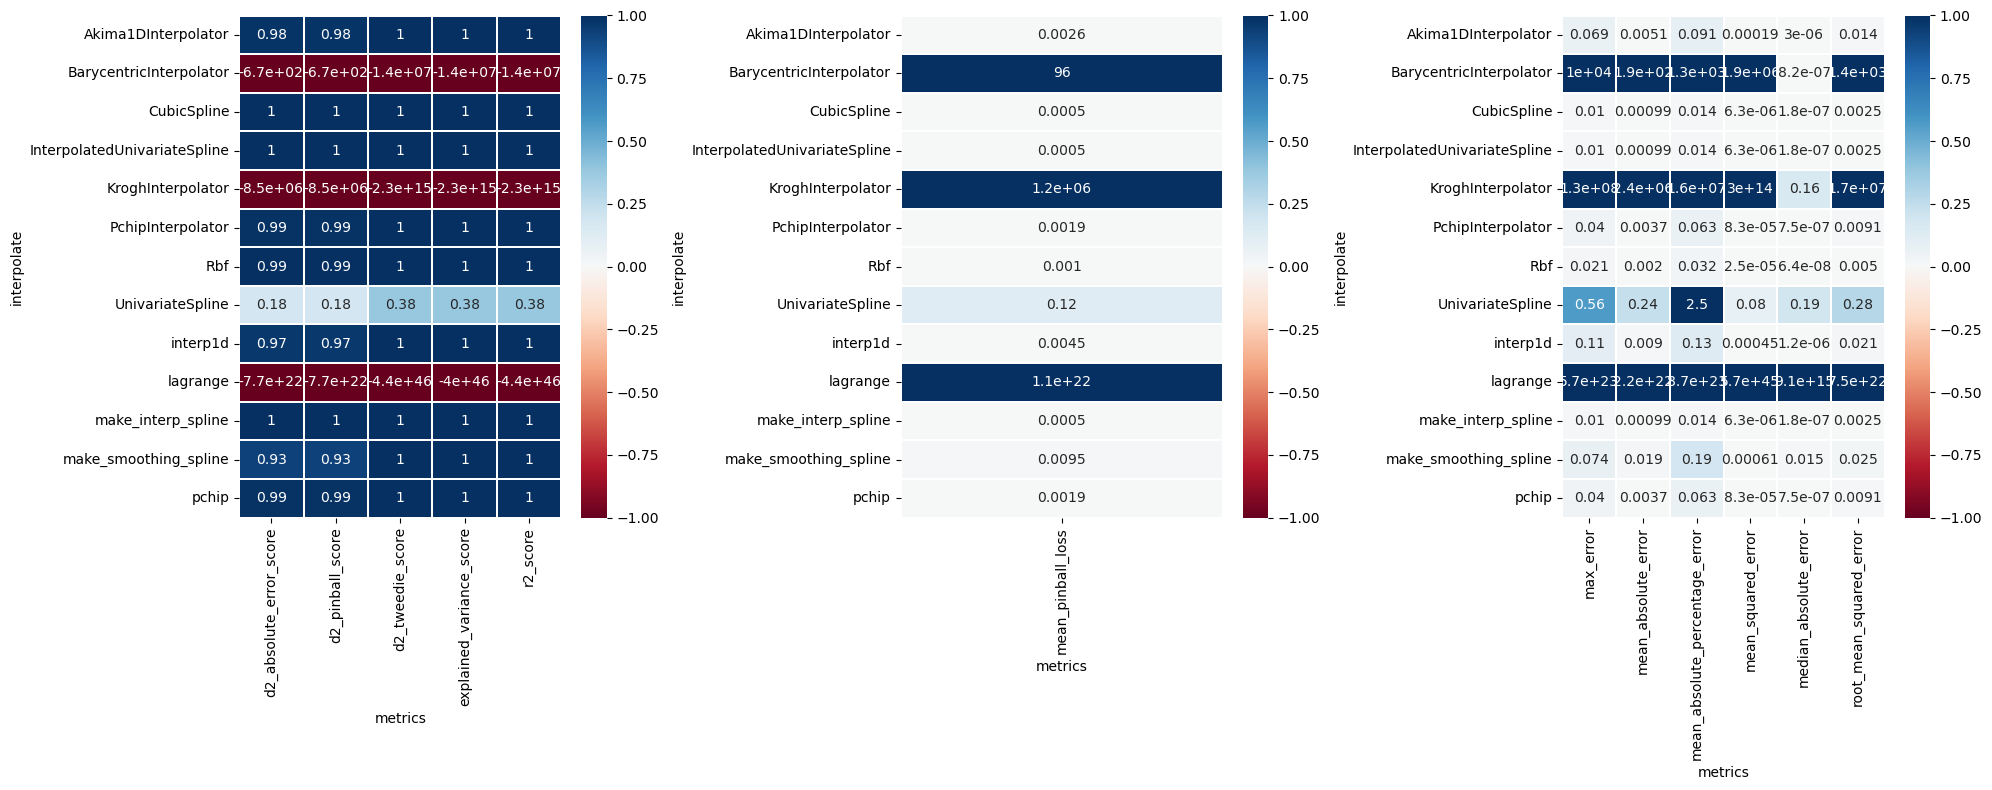

In [66]:
_, axs = plt.subplots(1, 3, figsize=(20, 8))

for ax, category in zip(axs, ['score', 'loss', 'error']):
    sns.heatmap(cross_df[[e for e in cross_df.columns if e.endswith(category)]], vmax=1, vmin=-1, cmap='RdBu', linewidths=0.1, annot=True, fmt='.2g', ax=ax)
    ax.tick_params(axis='x', rotation=90)

plt.tight_layout()
plt.show()